In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle

0
1
2
3
0
1
2
3


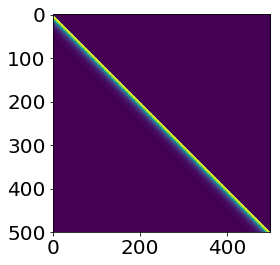

In [62]:
############################
### Load super voxel ids ###
############################

n_clusters = 2000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file)

###########################
### Create Notch Filter ###
###########################

fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = 0.2  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response
w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

###########################################
### Create estimate of gcamp6f kinetics ###
###########################################

def fit_eq(x, a, b, c, d, e):
    return a*(1-np.exp(-x/b))*(c*np.exp(-x/d)) + e

x = np.arange(0, 50, 1)
y = fit_eq(x, 1, 4, -1, 8, 0)

filter_ = y*-1
filter_padded = np.pad(filter_, (0, 450), 'constant')

toe = scipy.linalg.toeplitz(filter_padded,r=[0]*500)
plt.imshow(toe)

####################
### Load filters ###
####################
main_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210316_neural_weighted_behavior"

response_files = [os.path.join(main_path, file) for file in os.listdir(main_path) if 'responses' in file]
bbb.sort_nicely(response_files)

responses = []
for file in response_files:
    responses.append(np.load(file))
responses = np.asarray(responses)
responses_split = np.reshape(responses, (49-18,2000,4,500))

##########################
### Apply notch filter ###
##########################
responses_notch = signal.filtfilt(b_notch, a_notch, responses_split, axis=-1)

########################
### Deconvolve gcamp ###
########################

all_signals_unfiltered = np.reshape(responses_split[:,:,:,:],(31*2000,4,500))
all_signals = np.reshape(responses_notch,(31*2000,4,500))

all_signals_flipped = all_signals[:,:,::-1]
all_signals_deconv = []
for beh_idx in [0,1,2,3]:
    print(beh_idx)
    # flip filters in time
    temp = all_signals_flipped[:,beh_idx,:]

    # deconvolve
    deconv = np.linalg.lstsq(toe, temp.T)[0]
    deconv_smooth = gaussian_filter1d(deconv,sigma=3,axis=0)

    # Remove edge artifact
    deconv_smooth[:5,:] = deconv_smooth[5,:]
    deconv_smooth[-5:,:] = deconv_smooth[-5,:]

    # Flip back to being backwards in time
    deconv_smooth = deconv_smooth[::-1,:]
    all_signals_deconv.append(deconv_smooth)
all_signals_deconv = np.asarray(all_signals_deconv)
all_signals_deconv = np.swapaxes(all_signals_deconv,0,1)
all_signals_deconv = np.swapaxes(all_signals_deconv,0,2)

######################
### Get peaks, etc ###
######################

all_maxs = np.max(np.abs(all_signals_deconv),axis=-1)
thresholds = np.percentile(all_maxs,60,axis=0)

peaks = {}
peaks_ms = {}
peaks_unfiltered = {}
thresholded_filters_norm = {}
thresholded_filters_norm_unfiltered = {}
to_delete = {}
decay_times = {}
maxss = {}
for beh_idx in [0,1,2,3]:
    print(beh_idx)
    to_delete_ = np.where(all_maxs[:,beh_idx]<thresholds[beh_idx])
    thresholded_filters = np.delete(all_signals_deconv[:,beh_idx,:], to_delete_, axis=0)
    
    # add gaussian smoothing
    thresholded_filters = gaussian_filter1d(thresholded_filters,sigma=2,axis=-1)
    
    peaks_ = np.argmax(thresholded_filters,axis=-1)
    #idx_sort = np.argsort(peaks)
    maxs = np.max(thresholded_filters,axis=-1)
    maxss[beh_idx] = maxs
    
    thresholded_filters_norm_ = thresholded_filters/maxs[:,np.newaxis]
    
    peaks[beh_idx] = peaks_
    peaks_ms[beh_idx] = (peaks_-250)*20
    thresholded_filters_norm[beh_idx] = thresholded_filters_norm_
    to_delete[beh_idx] = to_delete_
    
    thresholded_filters_unfiltered = np.delete(all_signals_unfiltered[:,beh_idx,:], to_delete_, axis=0)
    maxs = np.max(thresholded_filters_unfiltered,axis=-1)
    thresholded_filters_norm_ = thresholded_filters_unfiltered/maxs[:,np.newaxis]
    thresholded_filters_norm_unfiltered[beh_idx] = thresholded_filters_norm_
    
    peaks_ = np.argmax(thresholded_filters_unfiltered,axis=-1)
    peaks_unfiltered[beh_idx] = peaks_
    
    # add tau finding
    decay_times_ = []
    decay_amount = .5
    for i in range(len(peaks[beh_idx])):
        trace = thresholded_filters_norm[beh_idx][i,:]
        try:
            decay_time = np.where((np.where(trace<decay_amount)[0] < peaks[beh_idx][i]) == False)[0][0]-1
        except:
            decay_time = 0
        decay_times_.append(decay_time)
    decay_times[beh_idx] = decay_times_
    
### Save output ###
to_save = ['thresholded_filters_norm', 'maxss', 'decay_times', 'peaks', 'to_delete']
for data in to_save:
    save_path = os.path.join(main_path, data + '.pickle')
    with open(save_path, 'wb') as handle:
        pickle.dump(eval(data), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
for beh_idx in [3]:
    behs = ['Vf', 'Vr+', 'Vr-', 'Wlk']

    add_deleted_voxels = np.zeros(62000)
    to_replace = [i for i in range(62000) if i not in to_delete[beh_idx][0]]
    #add_deleted_voxels[to_replace] = peaks[beh_idx] #cluster_ids #model.labels_ ### put signal here
    #add_deleted_voxels[to_replace] = peaks[beh_idx] - decay_times[beh_idx]
    add_deleted_voxels[to_replace] = maxss[beh_idx]
    to_plot = np.reshape(add_deleted_voxels, (31,2000))

    all_colored_by_betas = []
    for z in range(9,49-9):
        colored_by_betas = np.zeros(256*128)
        for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
            cluster_indicies = np.where(cluster_model_labels[z]==cluster_num)[0]
            colored_by_betas[cluster_indicies] = to_plot[z-9,cluster_num]
        colored_by_betas = colored_by_betas.reshape(256,128)
        all_colored_by_betas.append(colored_by_betas)
    all_colored_by_betas = np.asarray(all_colored_by_betas)
    # to_plot = np.max(all_colored_by_betas, axis=0)
    # plt.imshow(to_plot[:,:].T)
    #all_colored_by_betas[all_colored_by_betas==0] = np.nan

In [48]:
### Pad missing top and bottom z-slices

padding = np.zeros((9,256,128))
all_colored_by_betas = np.concatenate((padding, all_colored_by_betas, padding))
#all_colored_by_betas[all_colored_by_betas==0] = np.nan
all_colored_by_betas.shape

(49, 256, 128)

In [357]:
### viewing insta glm

# to load:
main_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210208_inst_uniq_glm/'

all_scores = []
for z in range(49):
    file = [os.path.join(main_dir, i) for i in os.listdir(main_dir) if f'Z{z}.' in i][0]
    with open(file, 'rb') as handle:
        scores = pickle.load(handle)
    all_scores.append(scores)

In [495]:
# scores1='scores_all'
# scores2='scores_zpos_unique'

#scores1='scores_zpos'
scores1='scores_all'
scores2='scores_walking'

all_colored_by_betas = []
for z in range(7,49-7):
    colored_by_betas = np.zeros(256*128)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(cluster_model_labels[z,:]==cluster_num)[0]
        if scores2 is not None:
            colored_by_betas[cluster_indicies] = all_scores[z][scores1][cluster_num] - all_scores[z][scores2][cluster_num]
        else:
            colored_by_betas[cluster_indicies] = all_scores[z][scores1][cluster_num]
        if len(cluster_indicies) > 100:
            colored_by_betas[cluster_indicies] = 0
        if colored_by_betas[cluster_indicies][0] == 1:
            colored_by_betas[cluster_indicies] = 0
    colored_by_betas = colored_by_betas.reshape(256,128)
    all_colored_by_betas.append(colored_by_betas)
all_colored_by_betas = np.asarray(all_colored_by_betas)
#to_plot = np.max(all_colored_by_betas, axis=0)

In [496]:
### Pad missing top and bottom z-slices

padding = np.zeros((7,256,128))
all_colored_by_betas = np.concatenate((padding, all_colored_by_betas, padding))
#all_colored_by_betas[all_colored_by_betas==0] = np.nan
all_colored_by_betas.shape

(49, 256, 128)

# Prep ROIs

In [11]:
### to cut out rois i will need to:
### 1) warp jfrc 2018 to my brain and apply params to atlas
### 2) relate my anat and func spaces

res_JFRC2018 = (0.38, 0.38, 0.38)
res_LUKE = (0.65, 0.65, 1)

### Fixed
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke.nii"
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = fixed[:,:,::-1] #flip z
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_LUKE)

### Moving
moving_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
moving = np.asarray(nib.load(moving_path).get_data().squeeze(), dtype='float32')
moving = ants.from_numpy(moving)
moving.set_spacing(res_JFRC2018)

### Atlas
atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210315_jfrc2018_atlas.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing(res_JFRC2018)

In [6]:
fixed.numpy().shape

(1024, 512, 256)

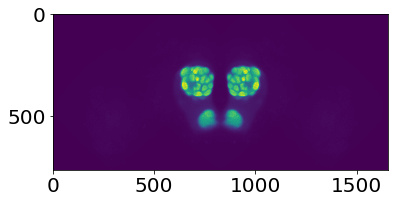

In [12]:
plt.imshow(moving.numpy()[:,:,80].T)

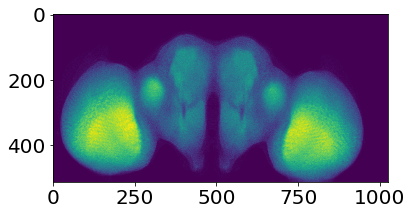

In [13]:
plt.imshow(fixed.numpy()[:,:,50].T)

In [14]:
t0 = time.time()
moco = ants.registration(fixed, moving, type_of_transform='SyN')
print(time.time()-t0)

1500.269294977188


In [41]:
mimic_moco = ants.apply_transforms(fixed, atlas, moco['fwdtransforms'], interpolator='genericLabel')

In [42]:
mimic_moco = mimic_moco[:,:,::-1]

In [16]:
mimic_moco.shape

(1024, 512, 256)

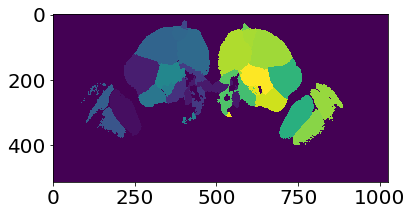

In [21]:
plt.imshow(mimic_moco[:,:,50].T)

In [25]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210412_crude_rois_in_luke'
nib.Nifti1Image(mimic_moco, np.eye(4)).to_filename(save_file)

In [11]:
res_LUKE = (0.65, 0.65, 1)
load_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210412_crude_rois_in_luke.nii'
mimic_moco = np.asarray(nib.load(load_file).get_data().squeeze(), dtype='float32')
#mimic_moco = ants.from_numpy(mimic_moco)
#mimic_moco.set_spacing(res_LUKE)

# Match func and anat dims

In [45]:
all_colored_by_betas.shape

(49, 256, 128)

In [46]:
mimic_moco.shape

(1024, 512, 256)

In [49]:
# want 128,256,49
func = np.swapaxes(all_colored_by_betas,0,2)
print(func.shape)

(128, 256, 49)


In [12]:
# Want 512,1024,256
anat = np.swapaxes(mimic_moco,0,1)
print(anat.shape)

(512, 1024, 256)


In [49]:
anat=anatomy

In [ ]:
# Both Y,X,Z - good

#### Interpolate both to be 1um isotropic

In [13]:
anat_iso = ants.resample_image(ants.from_numpy(anat),(int(512*0.65), int(1024*0.65), int(256*1)),1,0).numpy()

In [50]:
func_iso = ants.resample_image(ants.from_numpy(func),(int(512*0.65), int(1024*0.65), int(256*1)),1,1,).numpy()

In [51]:
anat_iso.shape, func_iso.shape

((332, 665, 256), (332, 665, 256))

In [52]:
FB = 26
rois = {'FB': 26, 'Medulla': 71, 'Lobula': 53, 'SLP_r': 27}
roi = 'FB'
anat_iso_mask = anat_iso.copy()
anat_iso_mask[np.where(anat_iso_mask != rois[roi])]=0
anat_iso_mask[np.where(anat_iso_mask != 0)]=1

In [53]:
masked_XY = np.max(func_iso*anat_iso_mask,axis=2)
masked_XY[np.where(masked_XY==0)] = np.nan
print(masked_XY.shape)

masked_XZ = np.max(func_iso*anat_iso_mask,axis=0)
masked_XZ[np.where(masked_XZ==0)] = np.nan
print(masked_XZ.shape)

masked_YZ = np.max(func_iso*anat_iso_mask,axis=1)
masked_YZ[np.where(masked_YZ==0)] = np.nan
print(masked_YZ.shape)

(332, 665)
(665, 256)
(332, 256)


In [54]:
start = 265
end = 235
middle = 250

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.Blues_r(np.linspace(0., 1, middle-end))
colors2 = plt.cm.Reds(np.linspace(0, 1, start-middle))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

mymap.set_bad(color='grey')

In [55]:
left_edge = np.where(np.sum(np.nan_to_num(masked_XY),axis=0)>0)[0][0]
right_edge = np.where(np.sum(np.nan_to_num(masked_XY),axis=0)>0)[0][-1]

top_edge = np.where(np.sum(np.nan_to_num(masked_XY),axis=1)>0)[0][0]
bottom_edge = np.where(np.sum(np.nan_to_num(masked_XY),axis=1)>0)[0][-1]

deep_edge = np.where(np.sum(np.nan_to_num(masked_XZ),axis=0)>0)[0][0]
shallow_edge = np.where(np.sum(np.nan_to_num(masked_XZ),axis=0)>0)[0][-1]

In [56]:
dim_x = right_edge-left_edge
dim_y = bottom_edge-top_edge
dim_z = shallow_edge-deep_edge

dim_x = dim_x / 100
dim_y = dim_y / 100
dim_z = dim_z / 100
print(dim_x, dim_y, dim_z)

1.04 0.81 0.75


In [374]:
masked_XY.shape

(332, 665)

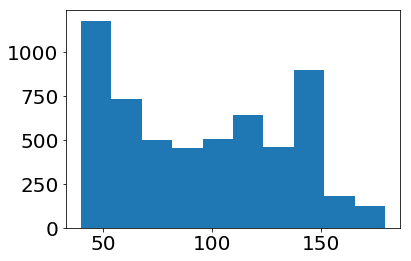

In [58]:
plt.hist(masked_XY.flatten());

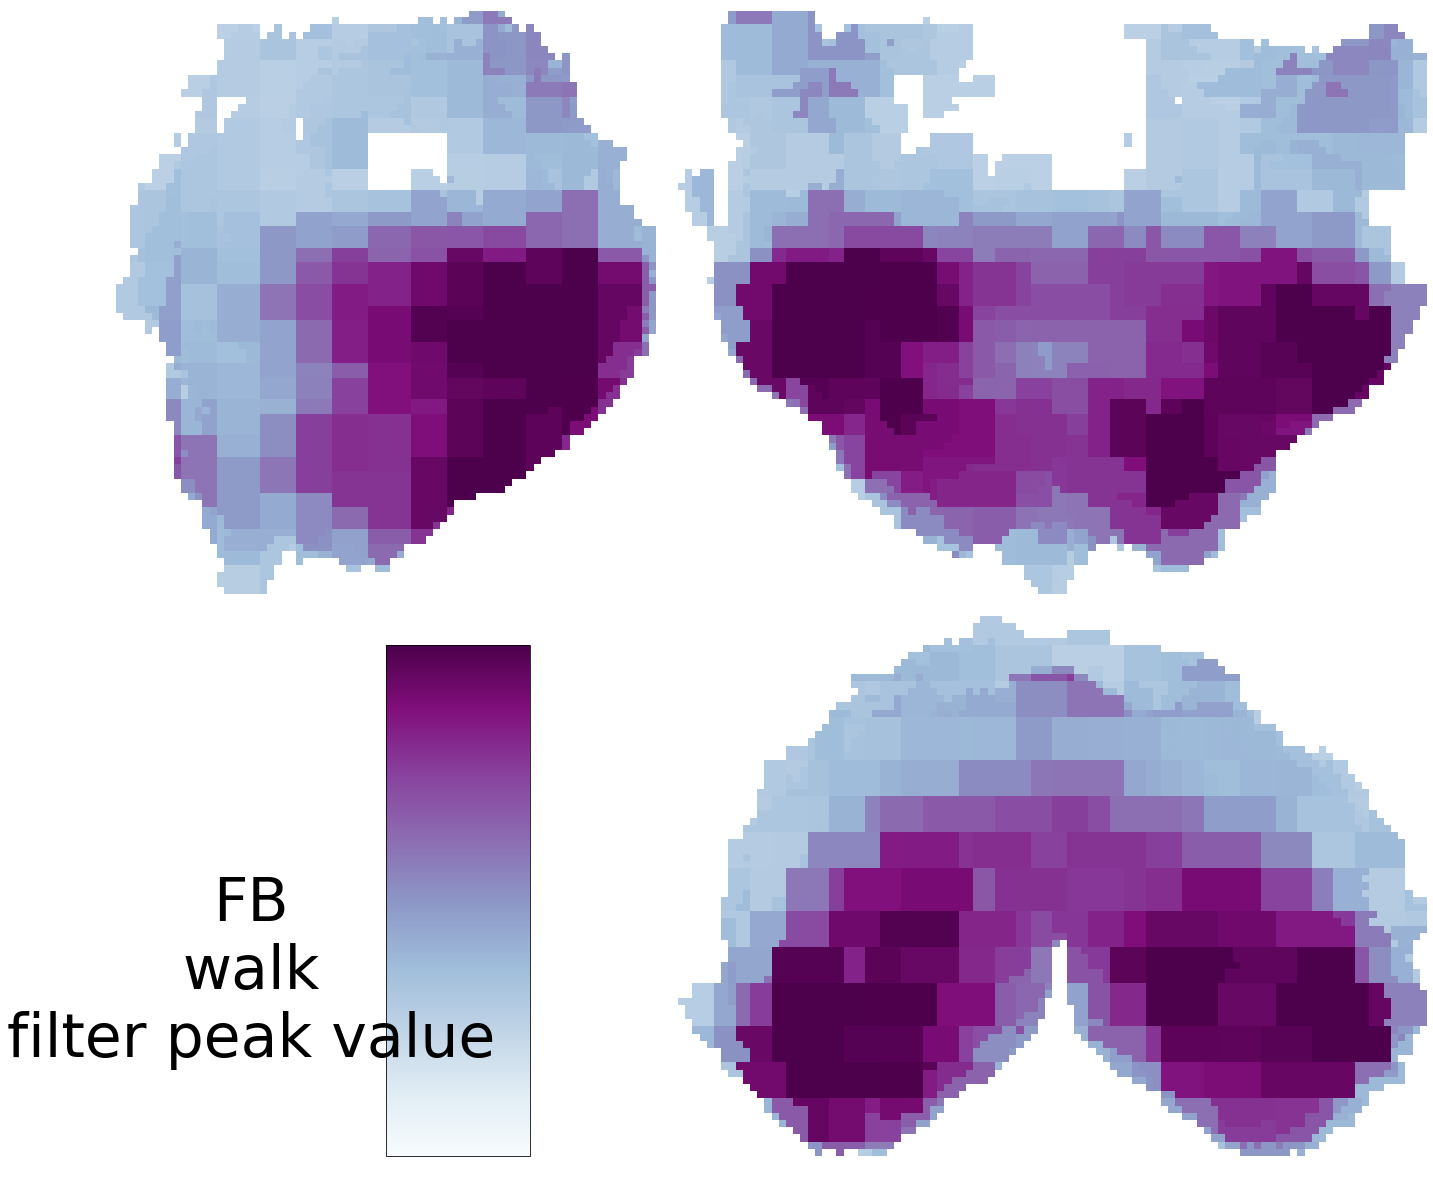

In [60]:
fig = plt.figure(figsize=(10,10))
space = .03

ax = fig.add_axes([dim_z+space,0,dim_x,dim_y])
colorbar_c = ax.imshow(masked_XY[top_edge:bottom_edge,left_edge:right_edge],cmap='BuPu',vmin=0,vmax=150);
ax.axis('off')

ax = fig.add_axes([0,0,dim_z,dim_y])
ax.imshow(masked_YZ[top_edge:bottom_edge, deep_edge:shallow_edge],cmap='BuPu',vmin=0,vmax=150);
ax.axis('off')

ax = fig.add_axes([dim_z+space,-dim_y+space,dim_x,dim_z])
ax.imshow(masked_XZ.T[deep_edge:shallow_edge,left_edge:right_edge],cmap='BuPu',vmin=0,vmax=150);
ax.axis('off')

plt.suptitle('FB\nwalk\nfilter peak value',fontsize=60,x=dim_z/4,y=(-dim_y+space)/2)

# Color Bar
axColor = plt.axes([dim_z/2,-dim_y+space,.2,dim_y-.1])
cbar = plt.colorbar(colorbar_c, cax = axColor, ticks=[start, middle, end])
cbar.ax.set_yticklabels(['300ms\n(Pre)', '0', '300ms\n(Post)'], fontsize=20)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

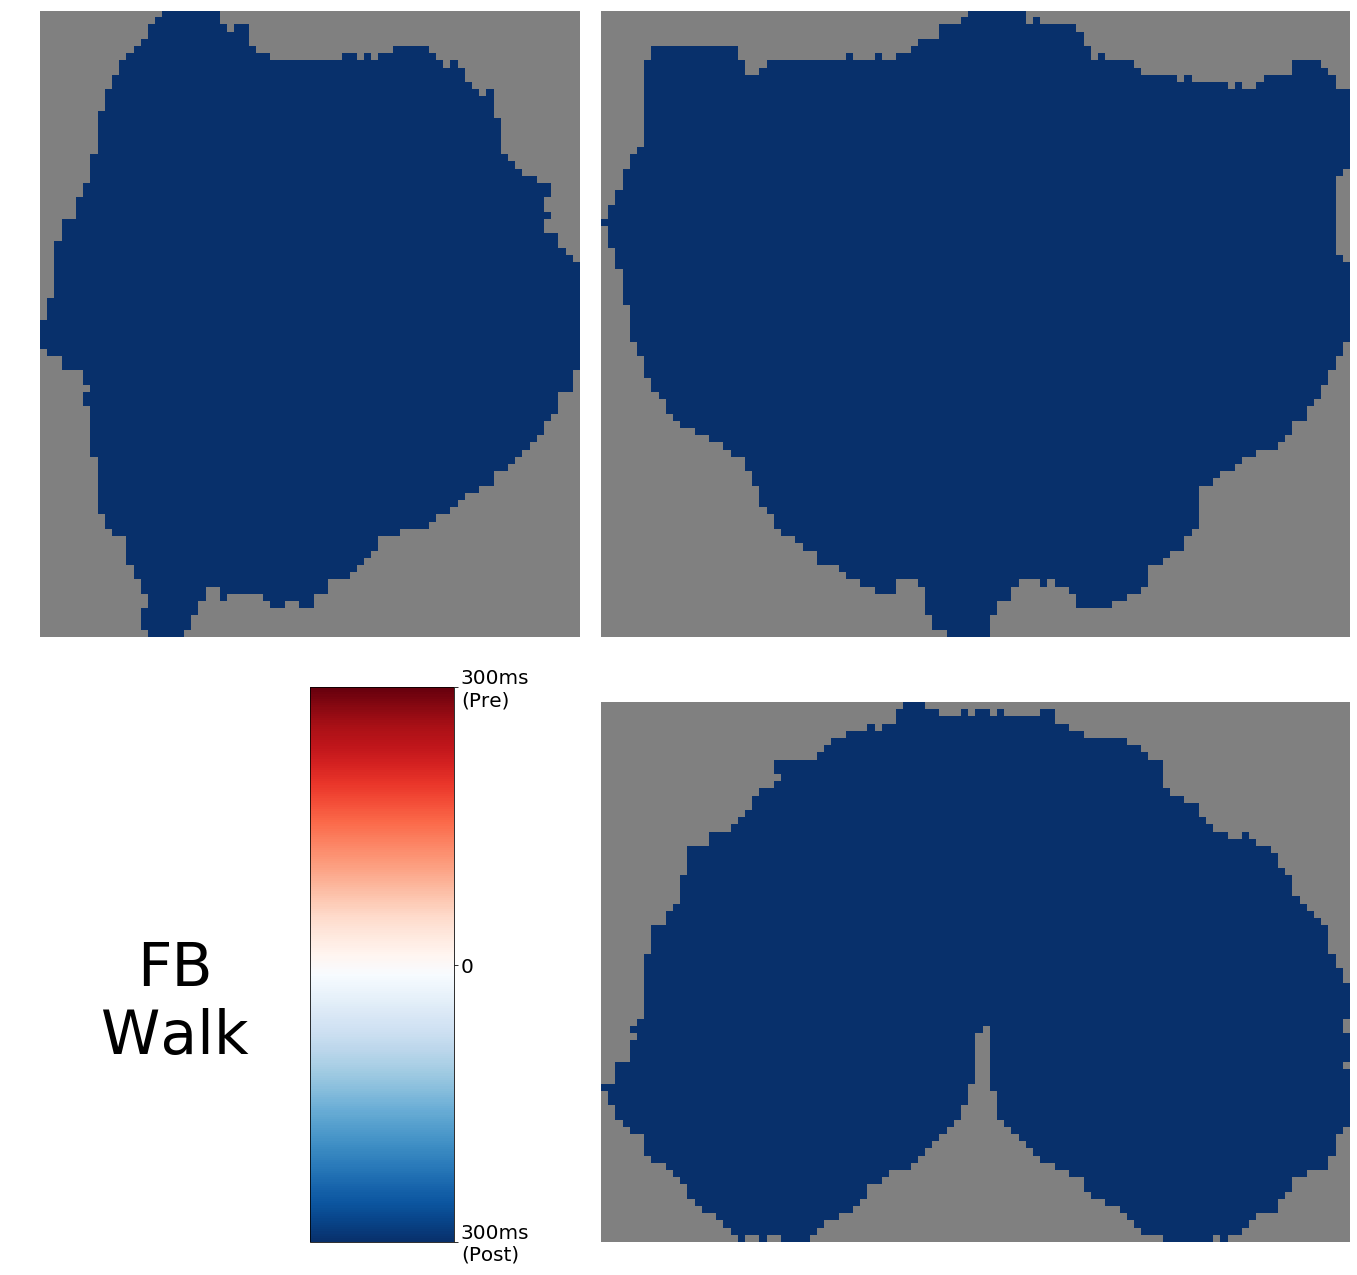

In [372]:
fig = plt.figure(figsize=(10,10))
space = .03

ax = fig.add_axes([dim_z+space,0,dim_x,dim_y])
colorbar_c = ax.imshow(masked_XY[top_edge:bottom_edge,left_edge:right_edge],cmap=mymap,vmin=end,vmax=start);
ax.axis('off')

ax = fig.add_axes([0,0,dim_z,dim_y])
ax.imshow(masked_YZ[top_edge:bottom_edge, deep_edge:shallow_edge],cmap=mymap,vmin=end,vmax=start);
ax.axis('off')

ax = fig.add_axes([dim_z+space,-dim_y+space,dim_x,dim_z])
ax.imshow(masked_XZ.T[deep_edge:shallow_edge,left_edge:right_edge],cmap=mymap,vmin=end,vmax=start);
ax.axis('off')

plt.suptitle('FB\nWalk',fontsize=60,x=dim_z/4,y=(-dim_y+space)/2)

# Color Bar
axColor = plt.axes([dim_z/2,-dim_y+space,.2,dim_y-.1])
cbar = plt.colorbar(colorbar_c, cax = axColor, ticks=[start, middle, end])
cbar.ax.set_yticklabels(['300ms\n(Pre)', '0', '300ms\n(Post)'], fontsize=20)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

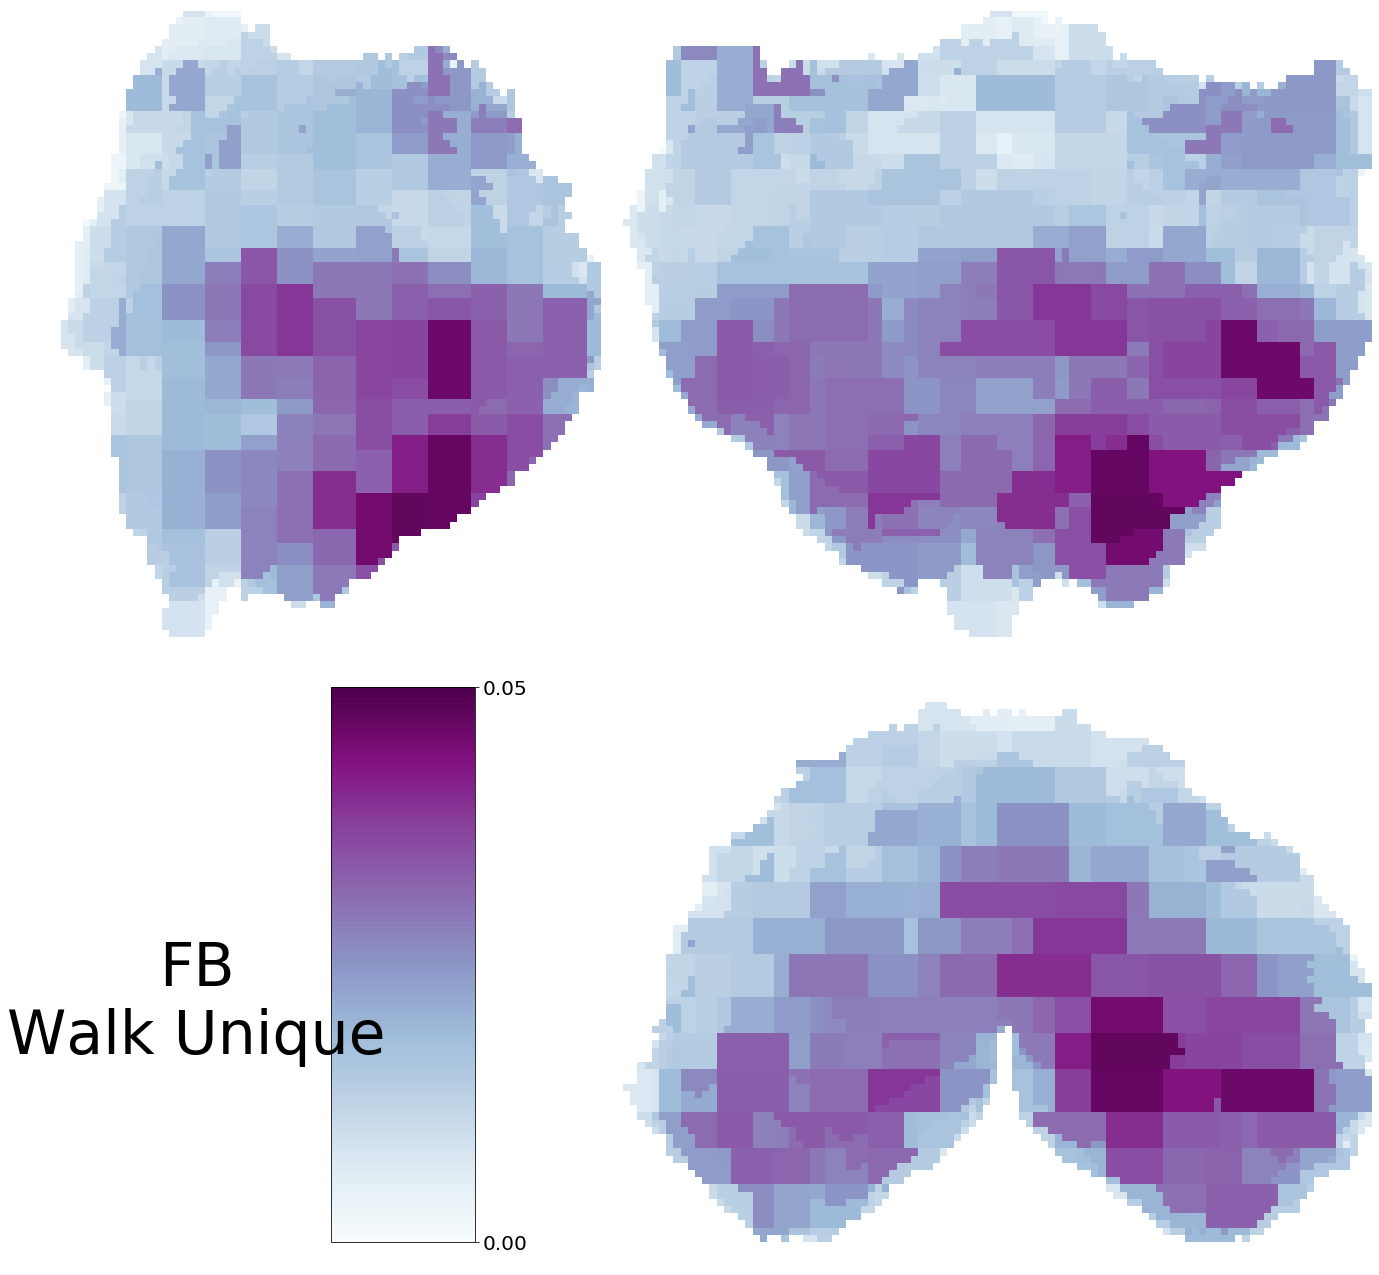

In [508]:
fig = plt.figure(figsize=(10,10))
space = .03

ax = fig.add_axes([dim_z+space,0,dim_x,dim_y])
colorbar_c = ax.imshow(masked_XY[top_edge:bottom_edge,left_edge:right_edge],cmap='BuPu',vmin=0,vmax=.05);
ax.axis('off')

ax = fig.add_axes([0,0,dim_z,dim_y])
ax.imshow(masked_YZ[top_edge:bottom_edge, deep_edge:shallow_edge],cmap='BuPu',vmin=0,vmax=.05);
ax.axis('off')

ax = fig.add_axes([dim_z+space,-dim_y+space,dim_x,dim_z])
ax.imshow(masked_XZ.T[deep_edge:shallow_edge,left_edge:right_edge],cmap='BuPu',vmin=0,vmax=.05);
ax.axis('off')

plt.suptitle('FB\nWalk Unique\n',fontsize=60,x=dim_z/4,y=(-dim_y+space)/2)

# Color Bar
axColor = plt.axes([dim_z/2,-dim_y+space,.2,dim_y-.1])
cbar = plt.colorbar(colorbar_c, cax = axColor, ticks=[0, .05])
#cbar.ax.set_yticklabels(['300ms\n(Pre)', '0', '300ms\n(Post)'], fontsize=20)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

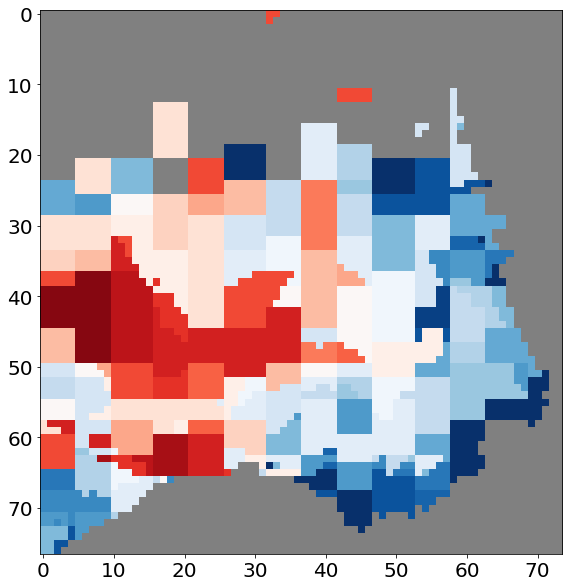

In [297]:
plt.figure(figsize=(10,10))
plt.imshow(masked_YZ[top_edge:bottom_edge, deep_edge:shallow_edge],cmap=mymap,vmin=end,vmax=start);

#cbar = fig.colorbar(cax, ticks=[start, middle, end],shrink=.8, anchor=(.1,.5))
#cbar.ax.set_yticklabels(['-300ms', '0', '+600ms'], fontsize=12)


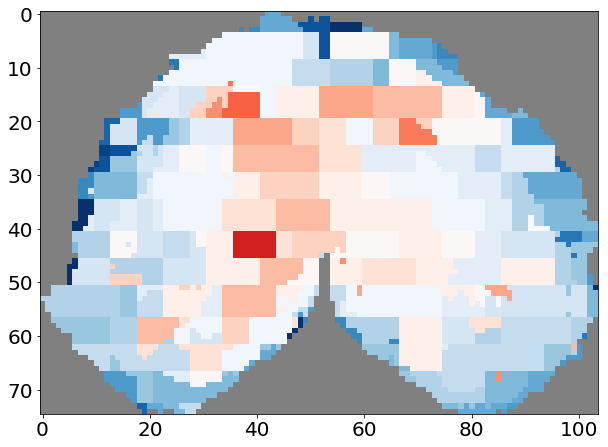

In [114]:
plt.figure(figsize=(10,10))
plt.imshow(masked_XZ.T[deep_edge:shallow_edge,left_edge:right_edge],cmap=mymap,vmin=end,vmax=start);

#cbar = fig.colorbar(cax, ticks=[start, middle, end],shrink=.8, anchor=(.1,.5))
#cbar.ax.set_yticklabels(['-300ms', '0', '+600ms'], fontsize=12)


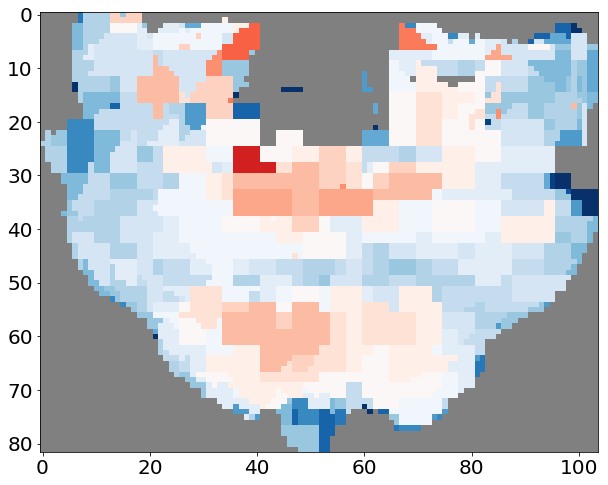

In [105]:
plt.figure(figsize=(10,10))
plt.imshow(masked_XY[top_edge:bottom_edge,left_edge:right_edge],cmap=mymap,vmin=end,vmax=start);

#cbar = fig.colorbar(cax, ticks=[start, middle, end],shrink=.8, anchor=(.1,.5))
#cbar.ax.set_yticklabels(['-300ms', '0', '+600ms'], fontsize=12)


In [93]:
top_edge

81

In [ ]:
fig = plt.figure(figsize=(20,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    #cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap=mymap,vmin=end,vmax=start);
    cax = grid[i].imshow(all_colored_by_betas[i,:,:].T,cmap='jet',vmin=end,vmax=start);
    grid[i].axis('off')